# Weather Data Exploratory Analysis

Weather data is obtained from the Synoptic weather [Time Series](http://dev3.synopticlabs.org:4000/mesonet/v2/stations/timeseries/) service. Weather data can be requested via API calls for recent weather data or for data covering a specific time period. 

The data we requested was captured by weather stations located in California. 

The end date of a request time cannot be before 1997/01/01

A long list of [variables](https://developers.synopticdata.com/mesonet/v2/api-variables/) is available to be included in the weather data, however individual stations capture a subset of the data included in the list. For our project we have focused on variables related to fire risk. 

Station metadata:

   - name, ID, stid: identifiers for the weather station
   - elevation, latitude, longitude: location of the weather station

Observations:

   - date_time
   - air_temp
   - precip_accum
   - relative_humidity
   - wind_direction
   - wind_speed

The JSON data includes one entry for each station, with the observations embedded in the JSON as lists of values. The observation list data was transformed into dataframe rows with station metadata alongside weather observations.


In [252]:
import pandas as pd
import numpy as np
import json
import math
from urllib.request import urlopen
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas_profiling as pp

## Load and Extract JSON Data

In [167]:
#Load data from file
dataPath = "E:/GitHub/w210_Wildfire/data/weather2hrvars.json"

with open(dataPath, 'r') as f:
    data = json.load(f)

In [180]:
#Get data via API call
response = urlopen("https://api.synopticdata.com/v2/stations/timeseries?state=ca&recent=120&&vars=air_temp,wind_speed,wind_direction,pressure,relative_humidity,cloud_layer_1_code,weather_cond_code,precip_accum&token=TOKEN")
json_data = response.read().decode('utf-8', 'replace')
data = json.loads(json_data)

### Extract the station data from JSON

In [178]:
station = json_normalize(data['STATION'])
station.shape

(3521, 39)

In [179]:
station.head(3)

,ELEVATION,ELEV_DEM,ID,LATITUDE,LONGITUDE,MNET_ID,NAME,OBSERVATIONS.air_temp_set_1,OBSERVATIONS.air_temp_set_2,OBSERVATIONS.cloud_layer_1_code_set_1,...,SENSOR_VARIABLES.relative_humidity.relative_humidity_set_1.position,SENSOR_VARIABLES.weather_cond_code.weather_cond_code_set_1.position,SENSOR_VARIABLES.wind_direction.wind_direction_set_1.position,SENSOR_VARIABLES.wind_direction.wind_direction_set_2.position,SENSOR_VARIABLES.wind_speed.wind_speed_set_1.position,SENSOR_VARIABLES.wind_speed.wind_speed_set_2.position,STATE,STATUS,STID,TIMEZONE
0,4383,4379.9,82,41.48362,-120.56150,1,Alturas,"[9.0, 9.0, 9.0, 8.0, 8.0, 8.0, 7.0, 7.0, 7.0, ...",NaN,"[703.0, 702.0, 706.0, 852.0, 756.0, 906.0, 1.0...",...,6.56,NaN,32.81,NaN,32.81,NaN,CA,ACTIVE,KAAT,America/Los_Angeles
1,217,180.4,84,40.97806,-124.10861,1,"Arcata / Eureka, Arcata Airport","[12.0, 12.0, 12.0, 12.0, 11.7, 12.0, 11.0, 11....",NaN,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",...,6.56,NaN,32.81,NaN,32.81,NaN,CA,ACTIVE,KACV,America/Los_Angeles
2,33,19.7,92,38.20750,-122.27944,1,"Napa, Napa County Airport","[15.0, 14.0, 14.0, 15.0, 14.4, 14.0, 14.0, 14....",NaN,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",...,6.56,NaN,32.81,NaN,32.81,NaN,CA,ACTIVE,KAPC,America/Los_Angeles


## Transform the JSON data into a dataframe of observations

#### Identify the observation and station metadata variables in the dataset

In [227]:
obsvars = ['NAME', 'ID', 'STID', 'ELEVATION', 'LATITUDE', 'LONGITUDE',
           'OBSERVATIONS.date_time', 'OBSERVATIONS.air_temp_set_1', 'OBSERVATIONS.precip_accum_set_1', 
           'OBSERVATIONS.relative_humidity_set_1', 'OBSERVATIONS.wind_direction_set_1',
           'OBSERVATIONS.wind_speed_set_1','STATUS']
observationsALL = station[obsvars]
observationsALL.shape

(3521, 13)

#### Create another observation set dropping rows which are missing observations.

In [221]:
observations = station[obsvars].dropna(axis=0, how='any') 
observations.shape

(449, 13)

In [222]:
observations.head(3)

,NAME,ID,STID,ELEVATION,LATITUDE,LONGITUDE,OBSERVATIONS.date_time,OBSERVATIONS.air_temp_set_1,OBSERVATIONS.precip_accum_set_1,OBSERVATIONS.relative_humidity_set_1,OBSERVATIONS.wind_direction_set_1,OBSERVATIONS.wind_speed_set_1,STATUS
101,CEDARVILLE,674,CEDC,4600,41.58528,-120.17139,"[2019-06-08T04:45:00Z, 2019-06-08T05:00:00Z, 2...","[5.84, 5.57, 3.67, 4.18, 3.24, 2.56]","[590.804, 590.804, 590.804, 590.804, 590.804, ...","[54.24, 59.5, 69.34, 70.83, 71.84, 74.81]","[357.1, 345.5, 317.9, 312.4, 313.7, 315.6]","[2.73, 2.12, 0.92, 0.85, 0.63, 0.55]",ACTIVE
125,ACTON,1712,ATNC1,2600,34.446389,-118.196800,"[2019-06-08T04:54:00Z, 2019-06-08T05:54:00Z]","[17.22, 14.44]","[267.716, 267.716]","[74.0, 82.0]","[156.0, 351.0]","[1.34, 0.9]",ACTIVE
126,ALDER POINT,1713,ALDC1,1059,40.186017,-123.591061,"[2019-06-08T04:51:00Z, 2019-06-08T05:51:00Z]","[11.11, 10.0]","[1322.578, 1322.578]","[70.0, 74.0]","[95.0, 29.0]","[0.45, 0.9]",ACTIVE


#### Convert the observation lists into dataset rows with station metadata

In [231]:
def extract_observations(obs):
    date_time = obs.iloc[6]
    dtlen = len(date_time)
    fake = [np.NaN]*dtlen
    name = [obs.iloc[0]]*dtlen
    ID = [obs.iloc[1]]*dtlen
    stid = [obs.iloc[2]]*dtlen
    elevation = [obs.iloc[3]]*dtlen
    latitude = [obs.iloc[4]]*dtlen
    longitude = [obs.iloc[5]]*dtlen
    air_temp = fake if not isinstance(obs.iloc[7], list) else obs.iloc[7]
    precip_accum = fake if not isinstance(obs.iloc[8], list) else obs.iloc[8]
    relative_humidity = fake if not isinstance(obs.iloc[9], list) else obs.iloc[9]
    wind_direction = fake if not isinstance(obs.iloc[10], list) else obs.iloc[10]
    wind_speed = fake if not isinstance(obs.iloc[11], list) else obs.iloc[11]
    obs_list = pd.DataFrame(np.column_stack([name, ID, stid, elevation, latitude, longitude, date_time, air_temp, precip_accum, relative_humidity, wind_direction, wind_speed]), 
                               columns=['name', 'ID', 'stid', 'elevation', 'latitude', 'longitude', 'date_time', 'air_temp', 'precip_accum', 'relative_humidity', 'wind_direction', 'wind_speed'])
    return obs_list

#tworow = observations.loc[observations['STID'].isin(['CEDC', 'ALDC1'])] 

weather = pd.DataFrame()

for i,row in observations.iterrows():
    e = extract_observations(row)
    weather = weather.append(e, ignore_index = True)
    
weather.head(5)

,name,ID,stid,elevation,latitude,longitude,date_time,air_temp,precip_accum,relative_humidity,wind_direction,wind_speed
0,CEDARVILLE,674,CEDC,4600,41.58528,-120.17139,2019-06-08T04:45:00Z,5.84,590.804,54.24,357.1,2.73
1,CEDARVILLE,674,CEDC,4600,41.58528,-120.17139,2019-06-08T05:00:00Z,5.57,590.804,59.5,345.5,2.12
2,CEDARVILLE,674,CEDC,4600,41.58528,-120.17139,2019-06-08T05:15:00Z,3.67,590.804,69.34,317.9,0.92
3,CEDARVILLE,674,CEDC,4600,41.58528,-120.17139,2019-06-08T05:30:00Z,4.18,590.804,70.83,312.4,0.85
4,CEDARVILLE,674,CEDC,4600,41.58528,-120.17139,2019-06-08T05:45:00Z,3.24,590.804,71.84,313.7,0.63


#### Type conversion for columns

In [244]:
floatcols = ['elevation', 'latitude', 'longitude', 'air_temp', 'precip_accum', 'relative_humidity', 'wind_direction', 'wind_speed']
strcols = ['name', 'ID', 'stid']
weather[floatcols] = weather[floatcols].apply(pd.to_numeric, downcast='float', errors='coerce')
weather[strcols] = weather[strcols].astype('str')
weather['date_time'] = pd.to_datetime(weather['date_time'])
weather.dtypes

name                         object
ID                           object
stid                         object
elevation                   float32
latitude                    float32
longitude                   float32
date_time            datetime64[ns]
air_temp                    float32
precip_accum                float32
relative_humidity           float32
wind_direction              float32
wind_speed                  float32
dtype: object

#### Create new features for month, year and day to look at weather trends

In [277]:
weather['hours'] = pd.DataFrame(weather.apply(lambda row: (row[6].time()).hour, 1))
weather['days'] = pd.DataFrame(weather.apply(lambda row: (row[6].date()).day, 1))
weather['months'] = pd.DataFrame(weather.apply(lambda row: (row[6].date()).month, 1))
weather['years'] = pd.DataFrame(weather.apply(lambda row: (row[6].date()).year, 1))
weather.head(5)

,name,ID,stid,elevation,latitude,longitude,date_time,air_temp,precip_accum,relative_humidity,wind_direction,wind_speed,hours,days,months,years
0,CEDARVILLE,674,CEDC,4600.0,41.585281,-120.171387,2019-06-08 04:45:00,5.84,590.804016,54.240002,357.100006,2.73,4,8,6,2019
1,CEDARVILLE,674,CEDC,4600.0,41.585281,-120.171387,2019-06-08 05:00:00,5.57,590.804016,59.500000,345.500000,2.12,5,8,6,2019
2,CEDARVILLE,674,CEDC,4600.0,41.585281,-120.171387,2019-06-08 05:15:00,3.67,590.804016,69.339996,317.899994,0.92,5,8,6,2019
3,CEDARVILLE,674,CEDC,4600.0,41.585281,-120.171387,2019-06-08 05:30:00,4.18,590.804016,70.830002,312.399994,0.85,5,8,6,2019
4,CEDARVILLE,674,CEDC,4600.0,41.585281,-120.171387,2019-06-08 05:45:00,3.24,590.804016,71.839996,313.700012,0.63,5,8,6,2019


### Exploratory Data Analysis

#### How many stations are there altogether?

In [245]:
station.shape[0]

3521

#### How many null observation were removed from the data set?

In [246]:
observationsALL.isnull().sum(axis = 0)

NAME                                       0
ID                                         0
STID                                       0
ELEVATION                                  0
LATITUDE                                   0
LONGITUDE                                  0
OBSERVATIONS.date_time                     0
OBSERVATIONS.air_temp_set_1              451
OBSERVATIONS.precip_accum_set_1         2439
OBSERVATIONS.relative_humidity_set_1     826
OBSERVATIONS.wind_direction_set_1       1218
OBSERVATIONS.wind_speed_set_1            819
STATUS                                     2
dtype: int64

#### How many stations are present in the current data set?

In [282]:
observations.shape[0]

449

It might be possible to retain more stations by not eliminating ones with nulls for humidity and wind direction.

#### For the remaining observations where are the stations located?

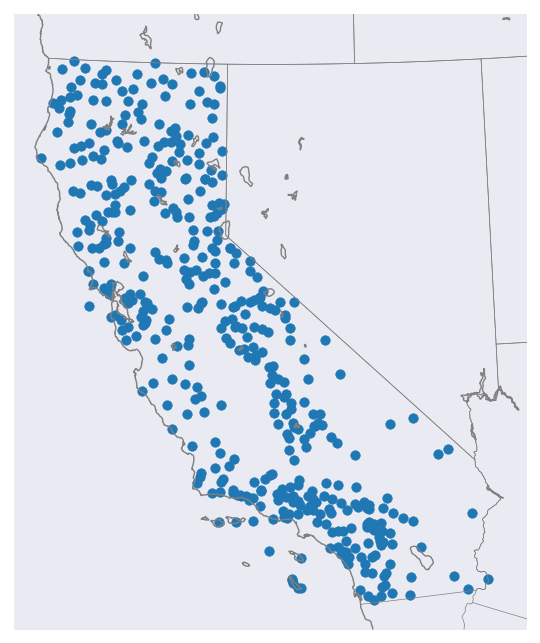

In [285]:
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution='h', 
            lat_0=37.5, lon_0=-119,
            width=1E6, height=1.2E6)
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.scatter(observations['LONGITUDE'].values, observations['LATITUDE'].values, latlon=True)


#### Summary description of the variables

In [248]:
weather.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
elevation,1028.0,3234.668213,2450.402100,-95.000000,950.000000,2797.000000,5050.000000,10971.000000
latitude,1028.0,37.261982,2.595607,32.600918,34.592587,37.588346,39.325562,41.999168
longitude,1028.0,-120.038597,2.043210,-124.266029,-121.609329,-120.076149,-118.591042,-114.474030
air_temp,1023.0,12.071926,6.374008,-40.000000,8.330000,12.780000,16.110001,32.220001
precip_accum,980.0,670.667603,493.466797,0.000000,323.850006,587.502014,913.638000,2980.436035
relative_humidity,1013.0,54.643196,24.105051,5.000000,35.000000,52.000000,73.000000,100.000000
wind_direction,973.0,203.671326,117.837029,0.000000,90.000000,234.000000,313.700012,360.000000
wind_speed,1016.0,2.481024,2.331603,0.000000,0.900000,1.790000,3.130000,15.200000


Looks like there still might be missing values for all measurements other than air_temp.

#### Profile of the data

In [256]:
profile = pp.ProfileReport(weather)
profile

Number of variables,12
Number of observations,1028
Total Missing (%),1.1%
Total size in memory,52.2 KiB
Average record size in memory,52.0 B
Numeric,8
Categorical,3
Boolean,0
Date,1
Text (Unique),0
Rejected,0


#### Are there any outliers or unexpected trends in the observations?

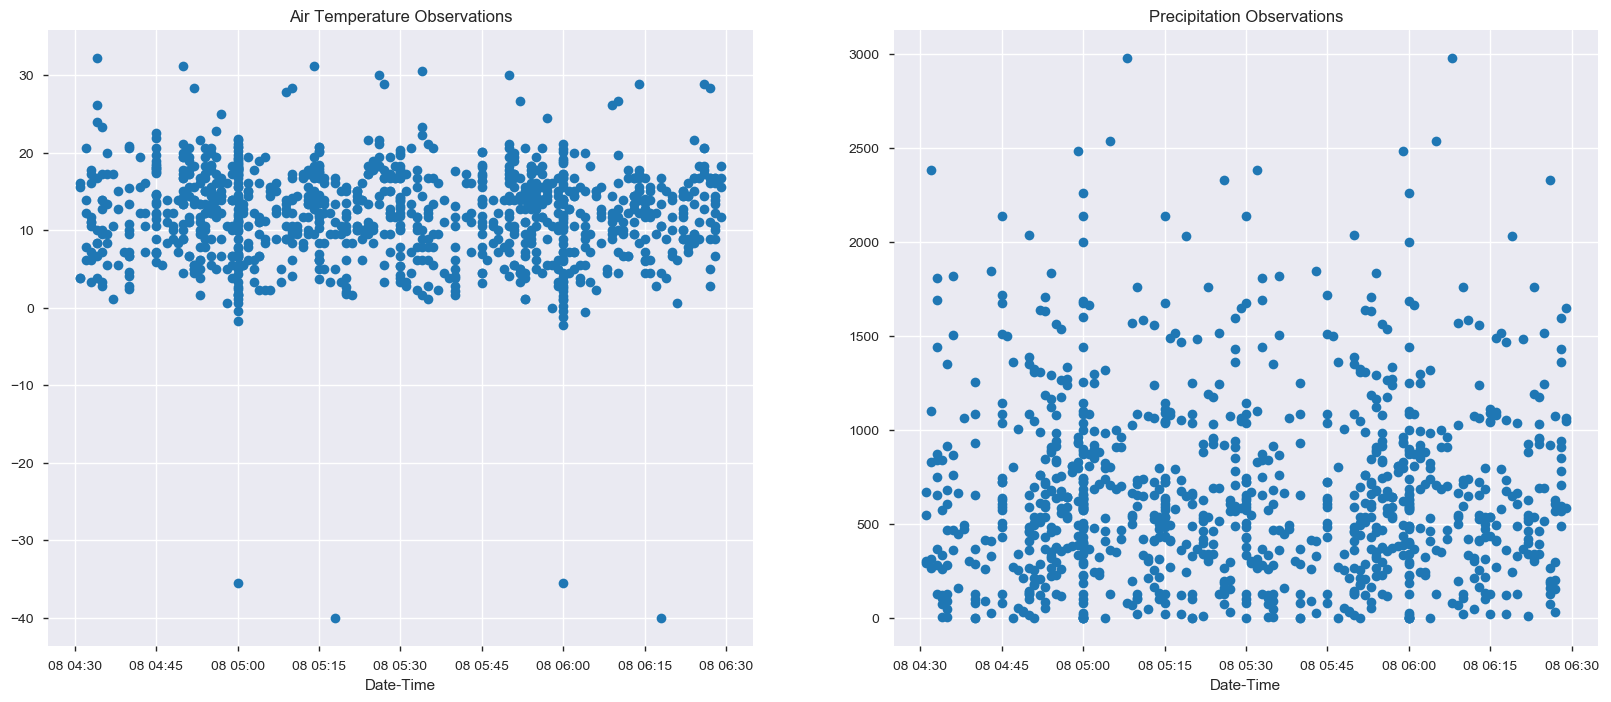

In [279]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot_date(weather['date_time'],weather['air_temp'])
plt.xlabel('Date-Time')
plt.title("Air Temperature Observations")
plt.subplot(1,2,2)
plt.plot_date(weather['date_time'],weather['precip_accum'])
plt.xlabel('Date-Time')
plt.title("Precipitation Observations")
plt.show()

Looks like there are 4 unexpectedly low values for temperature. Maybe those should not have been negative?

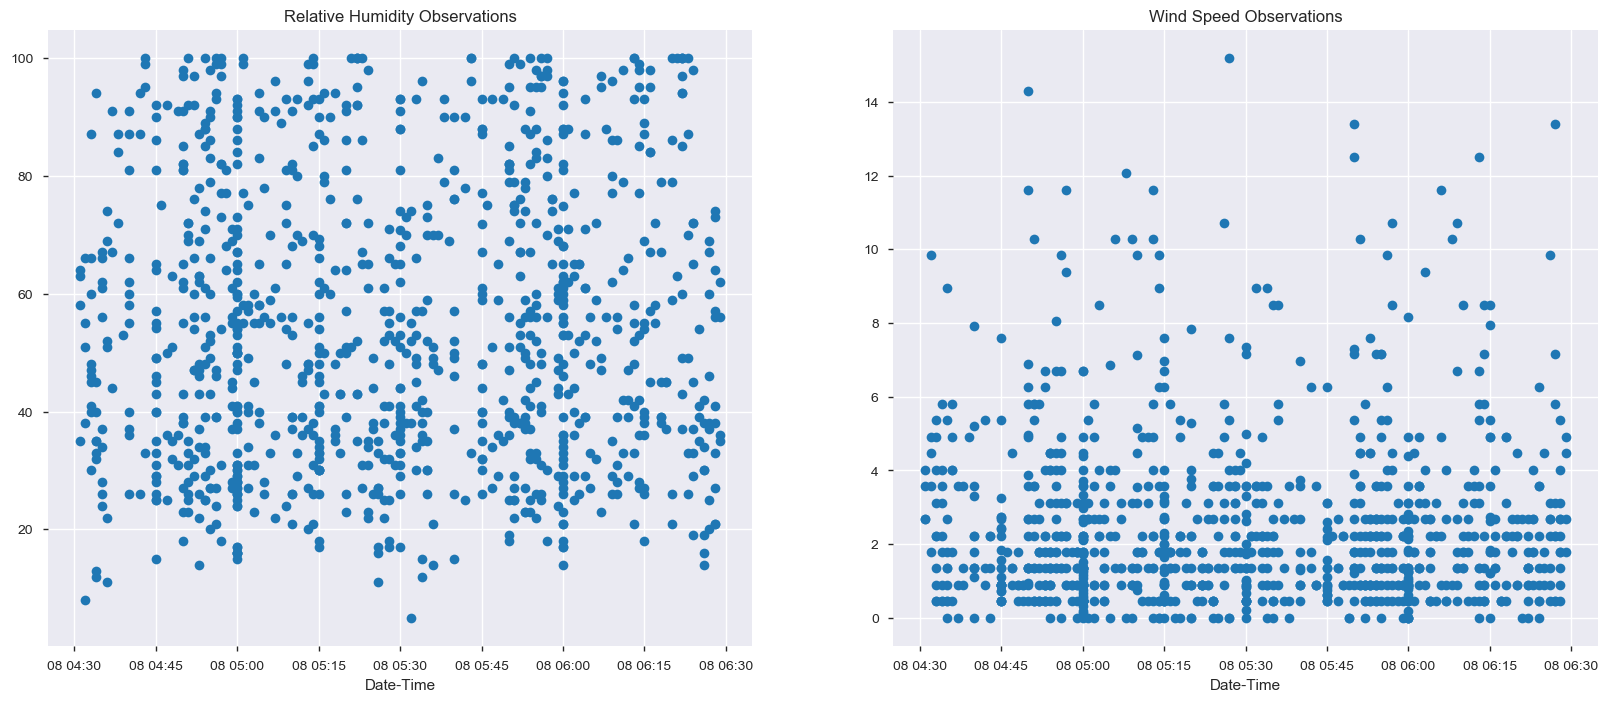

In [273]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot_date(weather['date_time'],weather['relative_humidity'])
plt.xlabel('Date-Time')
plt.title("Relative Humidity Observations")
plt.subplot(1,2,2)
plt.plot_date(weather['date_time'],weather['wind_speed'])
plt.xlabel('Date-Time')
plt.title("Wind Speed Observations")
plt.show()